# 2.2 KNN: Experimentando con activos

En este notebook vamos a volver al ejemplo que hemos visto en la Introducción del curso. Queremos predecir si las acciones de Apple van a subir o bajar a un mes vista a partir de una serie de precios de activos con el algoritmo K-Nearest Neighbors (KNN).

Para ello, vamos a seguir con el ejemplo de la Introducción, es decir, vamos a encontrar patrones similares de comportamiento en las series temporales.

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

## Descarga de datos y preprocesamiento

In [7]:
precios = pd.read_csv("https://raw.githubusercontent.com/christianolivamoya/MIAX13-ML/refs/heads/main/dataset/data_comp_SP500.csv")
precios.index = pd.to_datetime(precios["Date"])
precios = precios.drop(columns="Date")
precios

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,22.010019,2.527393,NaN,NaN,15.535000,7.495556,26.393572,39.919998,21.267511,20.790808,...,71.817345,14.521288,55.838711,12.267728,40.008057,NaN,14.978962,67.402054,34.880001,NaN
2007-01-04,22.080608,2.583492,NaN,NaN,15.830029,7.492222,26.988495,40.820000,21.636642,20.674070,...,71.995499,14.375073,55.861889,12.278193,39.257668,NaN,14.938252,68.905663,34.680000,NaN
2007-01-05,21.875275,2.565094,NaN,NaN,15.830029,7.418889,26.611225,40.619999,21.390556,20.641642,...,71.247040,14.329007,56.192532,12.032106,39.538406,NaN,14.808467,68.861954,34.330002,NaN
2007-01-08,21.798277,2.577761,NaN,NaN,15.887125,7.462222,26.995731,40.450001,21.558935,20.745407,...,70.765923,14.455191,57.253983,12.032106,39.219875,NaN,14.772831,68.416115,34.400002,NaN
2007-01-09,21.823936,2.791895,NaN,NaN,16.026716,7.392222,26.930435,39.630001,21.526560,20.239580,...,70.035217,14.381088,57.480175,12.026868,38.917580,NaN,14.828820,68.459839,34.340000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,144.250000,231.300003,194.099991,134.789993,116.699997,111.089996,364.600006,509.649994,236.429993,57.910000,...,292.649994,32.590000,103.949997,63.020000,124.080002,137.240005,134.649994,104.830002,377.679993,192.194565
2024-10-15,144.580002,233.850006,191.860001,133.270004,116.050003,108.059998,368.660004,508.029999,225.869995,57.669998,...,291.140015,33.049999,99.220001,63.430000,120.349998,136.679993,133.220001,104.599998,375.299988,191.935181
2024-10-16,139.110001,231.779999,190.460007,135.149994,117.820000,107.470001,372.260010,502.540009,227.490005,58.290001,...,291.299988,33.450001,100.239998,64.010002,120.660004,137.460007,133.350006,105.459999,375.500000,193.980331


In [8]:
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "NVDA", "V", "UNH", "PG", "HD", "MA", "BAC", "ADBE", "NFLX", "META", "TSLA", "JNJ", "WMT"]
YEAR_START = 2013
START_DATE = str(YEAR_START)+"-01-01"
data = precios.loc[START_DATE:, TICKERS]
data.head()

,AAPL,MSFT,AMZN,GOOGL,JPM,NVDA,V,UNH,PG,HD,MA,BAC,ADBE,NFLX,META,TSLA,JNJ,WMT
Date,,,,,,,,,,,,,,,,,,
2013-01-02,16.705696,22.451811,12.8655,18.054642,32.313251,0.293535,35.736618,45.537476,49.248260,48.451305,47.532612,9.721240,38.340000,13.144286,27.915949,2.357333,51.169823,18.031240
2013-01-03,16.494837,22.151054,12.9240,18.065126,32.248127,0.293766,35.764214,43.408394,48.935970,48.313915,47.600609,9.664675,37.750000,13.798571,27.686640,2.318000,51.097584,17.916658
2013-01-04,16.035381,21.736477,12.9575,18.422102,32.819736,0.303458,36.056324,43.491879,49.035332,48.222336,47.598751,9.785885,38.130001,13.711429,28.673668,2.293333,51.682663,17.984371
2013-01-07,15.941056,21.695833,13.4230,18.341721,32.855904,0.294689,36.313900,43.491879,48.701767,47.962814,48.423634,9.769724,37.939999,14.171429,29.331684,2.289333,51.574326,17.812496
2013-01-08,15.983959,21.582026,13.3190,18.305525,32.921024,0.288227,36.651997,42.915768,48.623688,48.252853,48.264263,9.680837,38.139999,13.880000,28.972765,2.245333,51.581532,17.861977


Recordad que, aunque no debemos descartar nunca la idea de trabajar con precios, en este caso concreto, para poder comparar activos debemos realizar nuestros cálculos con los retornos.

In [9]:
retornos = np.log(data).diff().dropna()
retornos.head()

,AAPL,MSFT,AMZN,GOOGL,JPM,NVDA,V,UNH,PG,HD,MA,BAC,ADBE,NFLX,META,TSLA,JNJ,WMT
Date,,,,,,,,,,,,,,,,,,
2013-01-03,-0.012702,-0.013486,0.004537,0.000581,-0.002017,0.000786,0.000772,-0.047883,-0.006361,-0.002840,0.001430,-0.005836,-0.015508,0.048578,-0.008248,-0.016826,-0.001413,-0.006375
2013-01-04,-0.028250,-0.018893,0.002589,0.019568,0.017570,0.032460,0.008134,0.001921,0.002028,-0.001897,-0.000039,0.012464,0.010016,-0.006335,0.035029,-0.010699,0.011385,0.003772
2013-01-07,-0.005900,-0.001872,0.035295,-0.004373,0.001101,-0.029323,0.007118,0.000000,-0.006826,-0.005396,0.017181,-0.001653,-0.004995,0.032998,0.022689,-0.001746,-0.002098,-0.009603
2013-01-08,0.002688,-0.005259,-0.007778,-0.001975,0.001980,-0.022170,0.009267,-0.013335,-0.001604,0.006029,-0.003297,-0.009140,0.005258,-0.020779,-0.012312,-0.019407,0.000140,0.002774
2013-01-09,-0.015752,0.005634,-0.000113,0.006551,-0.000660,-0.022673,0.015133,0.018696,0.005386,-0.000791,0.027748,-0.046997,0.013542,-0.012949,0.051311,-0.001188,0.004471,-0.000292


## Definición de un patrón

Para poder encontrar patrones de comportamiento, lo primero que debemos hacer es definir un vector de características.

En este caso, nuestro vector va a estar definido con los retornos del activo en un mes determinado. Hagamos un ejemplo:

Veamos el vector de características de Apple (AAPL) en el mes de octubre de 2021:

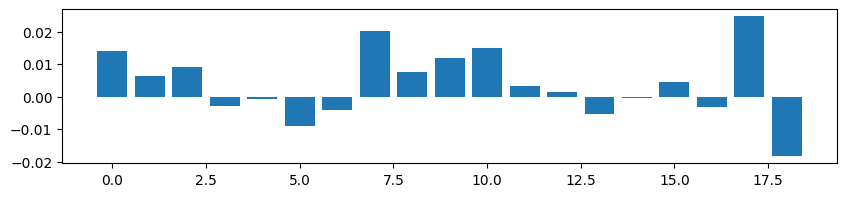

En el mes siguiente a este vector, Apple tuvo una rentabilidad del 9.99 %


In [10]:
anno_base = 2021
mes_base = 10
fecha = str(anno_base) + "-" + str(mes_base)
fecha_target = str(anno_base) + "-" + str(mes_base+1)
base = retornos.AAPL[fecha].values[-19:]
target = retornos.AAPL[fecha_target].sum()

plt.figure(figsize=(10,2))
plt.bar(range(len(base)), base.T)
plt.show()
print("En el mes siguiente a este vector, Apple tuvo una rentabilidad del", np.around(target*100, decimals=2), "%")

## Predicción

Una vez tenemos el vector de características `base`, nuestro objetivo es encontrar a lo largo del tiempo y de entre todos los activos que estamos estudiando, aquellos K vectores más próximos con la siguiente hipótesis:

**Voy a asumir que aquellos activos que más se parezcan a mí hoy, se van a comportar como yo el mes que viene**

Como KNN utiliza la distancia euclídea para encontrar patrones cercanos, vamos a utilizar este algoritmo. Para ello, tenemos que construir un dataset con la información de todas las ventanas que queramos utilizar.

In [11]:
datos_x = []
datos_y = []
datos_dict = {}

for anno in range(YEAR_START, anno_base+1):
  mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
  for mes in range(1, mes_max):
    fecha = str(anno) + "-" + str(mes)
    fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
    for activo in TICKERS:
      vector = retornos[activo][fecha].values[-19:]
      target = retornos[activo][fecha_target].sum()
      datos_x.append(vector)
      datos_y.append(target)
      datos_dict[len(datos_x)-1] = (activo, fecha)
datos_x = np.array(datos_x)
datos_y = np.array(datos_y)
datos_x.shape, datos_y.shape

((1890, 19), (1890,))

Una vez hemos construido el dataset, es tan sencillo como utilizar la clase KNeighborsClassifier de sklearn.

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(datos_x, datos_y > 0)

# Queremos saber si nuestro vector base va a subir o bajar al mes siguiente habiendo
# mirado los 5 vecinos más cercanos.
knn.predict(base[None, :])

array([ True])

In [13]:
# El método kneighbors te permite saber las distancias mínimas y el índice de los datos
knn.kneighbors(base[None, :])

(array([[0.03484924, 0.03905868, 0.03937711, 0.03938841, 0.04101002]]),
 array([[ 307,  820, 1798,  979, 1070]]))

In [14]:
# Utilizando kneighbors y el diccionario que hemos creado, podemos recuperar los activos
# y las fechas
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  print(datos_dict[i_vecino])

('MSFT', '2014-6')
('MA', '2016-10')
('JNJ', '2021-4')
('UNH', '2017-7')
('PG', '2017-12')


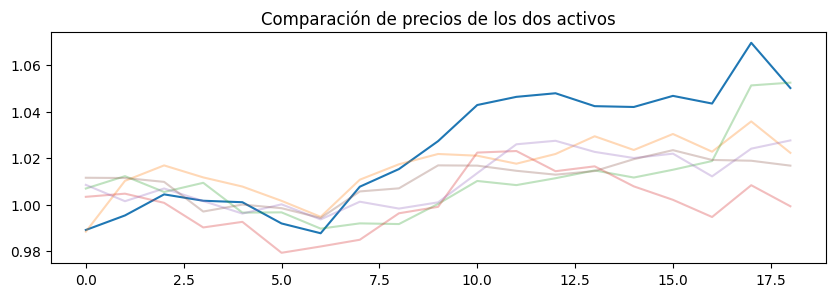

In [15]:
plt.figure(figsize=(10, 3))
plt.title("Comparación de precios de los dos activos")
plt.plot(range(19), (precios.AAPL["2021-10"]/precios.AAPL["2021-10"].iloc[0])[-19:])
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  ticker, fecha = datos_dict[i_vecino]
  plt.plot(range(19), (precios[ticker][fecha]/precios[ticker][fecha].iloc[0])[-19:], alpha=0.3)
plt.show()

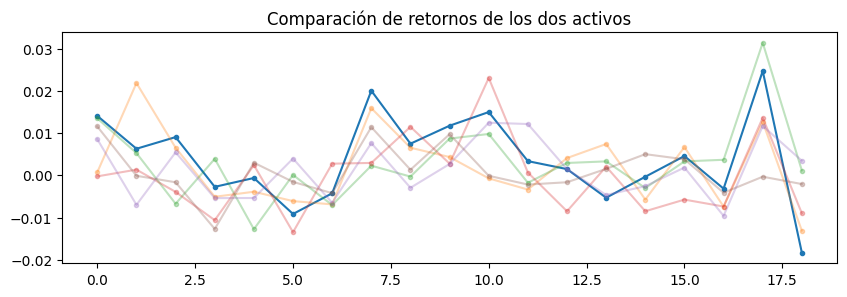

In [16]:
plt.figure(figsize=(10, 3))
plt.title("Comparación de retornos de los dos activos")
plt.plot(range(19), (retornos.AAPL["2021-10"])[-19:], '.-')
for i_vecino in knn.kneighbors(base[None, :])[1][0]:
  ticker, fecha = datos_dict[i_vecino]
  plt.plot(range(19), (retornos[ticker][fecha])[-19:], '.-', alpha=0.3)
plt.show()

## Construcción de nuestro algoritmo

Siguiendo la hipotesis de que **asumir que aquellos K activos que más se parezcan a mí hoy, se van a comportar como yo el mes que viene**, vamos a intentar predecir el valor de Apple desde enero de 2020 hasta diciembre de 2023.

**Observación**: Recuerda que siempre hay que predecir a futuro con datos hasta la fecha, nunca podemos parecernos a alguien que aún no ha existido.

**Observación 2**: Si K=1, volvemos a hacer el mismo cálculo que hicimos en el notebook 1.1 Introducción.

In [17]:
ticker = "AAPL"
K = 3

targets = []
targets_real = []
preds = []
for anno_base in range(2020, 2024):
  for mes_base in range(1, 13):
    fecha_base = str(anno_base) + "-" + str(mes_base)
    print(fecha_base)
    base = retornos[ticker][fecha_base].values[-19:]
    if mes_base == 12:
      fecha_base_target = str(anno_base+1) + "-01"
    else:
      fecha_base_target = str(anno_base) + "-" + str(mes_base+1)
    target = retornos[ticker][fecha_base_target].sum()
    targets.append(target>0)
    targets_real.append(target)

    datos_x = []
    datos_y = []
    datos_dict = {}

    for anno in range(YEAR_START, anno_base+1):
      mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
      for mes in range(1, mes_max):
        fecha = str(anno) + "-" + str(mes)
        fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
        for activo in TICKERS:
          vector = retornos[activo][fecha].values[-19:]
          target = retornos[activo][fecha_target].sum()
          datos_x.append(vector)
          datos_y.append(target)
          datos_dict[len(datos_x)-1] = (activo, fecha)
    datos_x = np.array(datos_x)
    datos_y = np.array(datos_y)

    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(datos_x, datos_y > 0)
    pred = knn.predict(base[None, :])[0]
    preds.append(pred)

2020-1
2020-2
2020-3
2020-4
2020-5
2020-6
2020-7
2020-8
2020-9
2020-10
2020-11
2020-12
2021-1
2021-2
2021-3
2021-4
2021-5
2021-6
2021-7
2021-8
2021-9
2021-10
2021-11
2021-12
2022-1
2022-2
2022-3
2022-4
2022-5
2022-6
2022-7
2022-8
2022-9
2022-10
2022-11
2022-12
2023-1
2023-2
2023-3
2023-4
2023-5
2023-6
2023-7
2023-8
2023-9
2023-10
2023-11
2023-12


In [18]:
preds = np.array(preds)
targets = np.array(targets)
targets_real = np.array(targets_real)

Veamos ahora qué resultados obtenemos con nuestra estrategia. Calculemos el accuracy (porcentaje de acierto).

In [19]:
print(" > ACCURACY:", np.mean(preds == targets))

 > ACCURACY: 0.5833333333333334


Hagamos una sencilla simulación, asumiendo que no hay gastos de gestión.

- Cuando predecimos que va a subir, invertimos todo nuestro dinero en Apple.

- Cuando predecimos que va a bajar, vendemos todas nuestras acciones de Apple.

In [20]:
DINERO_INI = 1000
dinero = DINERO_INI
for pred, target in zip(preds, targets_real):
  if pred == True: # Va a subir
    dinero = dinero + dinero * target
  else: # Va a bajar
    dinero = dinero
print(dinero)

1938.187237955808


In [21]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 93.82 %
 > Rentabilidad anual: 23.45 %


**El resultado es peor que cuando K=1**

Si comparamos con invertir el dinero en Apple en enero del 2020 y dejarlo ahí durante 4 años:

In [25]:
DINERO_INI = 1000
dinero = DINERO_INI
for target in retornos[ticker].resample("ME").sum()["2020":"2023"]:
  dinero = dinero + dinero * target
print(dinero)

2237.9804408922932


In [26]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 123.8 %
 > Rentabilidad anual: 30.95 %


**Hagamos una modificación del algoritmo**

En lugar de utilizar el valor de clasificación True o False, utilicemos el valor real de cada ventana.

In [27]:
ticker = "AAPL"
K = 3

targets = []
targets_real = []
preds = []
preds_real = []
for anno_base in range(2020, 2024):
  for mes_base in range(1, 13):
    fecha_base = str(anno_base) + "-" + str(mes_base)
    print(fecha_base)
    base = retornos[ticker][fecha_base].values[-19:]
    if mes_base == 12:
      fecha_base_target = str(anno_base+1) + "-01"
    else:
      fecha_base_target = str(anno_base) + "-" + str(mes_base+1)
    target = retornos[ticker][fecha_base_target].sum()
    targets.append(target>0)
    targets_real.append(target)

    datos_x = []
    datos_y = []
    datos_dict = {}

    for anno in range(YEAR_START, anno_base+1):
      mes_max = mes_base if anno == anno_base else 13 ### OJO: Siempre tengo que buscar en el pasado para predecir bien
      for mes in range(1, mes_max):
        fecha = str(anno) + "-" + str(mes)
        fecha_target = str(anno+1) + "-01" if mes == 12 else str(anno) + "-" + str(mes+1)
        for activo in TICKERS:
          vector = retornos[activo][fecha].values[-19:]
          target = retornos[activo][fecha_target].sum()
          datos_x.append(vector)
          datos_y.append(target)
          datos_dict[len(datos_x)-1] = (activo, fecha)
    datos_x = np.array(datos_x)
    datos_y = np.array(datos_y)

    # NUEVO: El cambio consiste en entrenar un KNN para regresión en lugar de clasificación
    # weights = "distance" --> closer neighbors of a query point will have a greater influence than neighbors which are further away.
    knn = KNeighborsRegressor(n_neighbors=K, weights="distance")
    knn.fit(datos_x, datos_y)
    pred = knn.predict(base[None, :])[0]
    preds.append(pred > 0)
    preds_real.append(pred)

2020-1
2020-2
2020-3
2020-4
2020-5
2020-6
2020-7
2020-8
2020-9
2020-10
2020-11
2020-12
2021-1
2021-2
2021-3
2021-4
2021-5
2021-6
2021-7
2021-8
2021-9
2021-10
2021-11
2021-12
2022-1
2022-2
2022-3
2022-4
2022-5
2022-6
2022-7
2022-8
2022-9
2022-10
2022-11
2022-12
2023-1
2023-2
2023-3
2023-4
2023-5
2023-6
2023-7
2023-8
2023-9
2023-10
2023-11
2023-12


In [28]:
preds = np.array(preds)
preds_real = np.array(preds_real)
targets = np.array(targets)
targets_real = np.array(targets_real)

In [29]:
print(" > ACCURACY:", np.mean(preds == targets))

 > ACCURACY: 0.6875


In [30]:
error = np.sqrt((preds_real - targets_real)**2)
print(" > ERROR CUADRÁTICO PROMEDIO:", np.around(np.mean(error)*100, decimals=2), "% +-", np.around(np.std(error)*100, decimals=2), "%")

 > ERROR CUADRÁTICO PROMEDIO: 7.14 % +- 5.14 %


In [31]:
DINERO_INI = 1000
dinero = DINERO_INI
for pred, target in zip(preds, targets_real):
  if pred == True: # Va a subir
    dinero = dinero + dinero * target
  else: # Va a bajar
    dinero = dinero
print(dinero)

3143.1878412842866


In [32]:
rent = (dinero - DINERO_INI) / DINERO_INI * 100
print(" > Rentabilidad a cuatro años:", np.around(rent, decimals=2), "%")
print(" > Rentabilidad anual:", np.around(rent/4, decimals=2), "%")

 > Rentabilidad a cuatro años: 214.32 %
 > Rentabilidad anual: 53.58 %


**DISCUSIÓN DE LOS RESULTADOS**

- KNN es un buen algoritmo si quieres encontrar similitud entre puntos.

- KNN es sensible a utilizarlo como clasificador o como regresor. Si, como en este caso, estás perdiendo mucha información al decir solo True o False, quizás es una buena opción utilizar una regresión.